<a href="https://colab.research.google.com/github/Shuan-Yuhsuan/Face-Recognition-2021/blob/main/Outlet_Membership_Analysis_production.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **DATA ANALYTICS PROJECT - OUTLET MEMBERSHIP PROGRAM**
DATASET: Local outlet chain data including
1. Membership
2. Transactions in 2019
3. Business categories
4. Rewards record
5. Associative table: Card IDs

QUESTIONS
- Who are the most valuable members? What's their behavior pattern & how to target them?
- Whhat kind of promotion campaigns are most effective?

SUMMARY
- 


## Notebook Setup
Set up the environment & Read the datasets

In [ ]:
# ACCESS GOOGLE DRIVE
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Change Directory
import os
dir = '/content/drive/MyDrive/Data Analyst Projects/Outlet/Datasets'

if os.getcwd() != dir:
  os.chdir(dir)
  print(f'changed directory to {dir}')
else:
  print(f'already in {dir}')

changed directory to /content/drive/MyDrive/Data Analyst Projects/Outlet/Datasets


In [ ]:
# import libraries
import numpy as np
import pandas as pd
from sklearn import cluster
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

In [ ]:
# Take a look at the files
# os.chdir('Datasets')
# ! ls

#### Read Datasets

In [ ]:
membership = pd.read_csv('Membership.csv')
cards = pd.read_csv('Cards.csv')
rewards = pd.read_csv('Rewards.csv')
transactionMeta = pd.read_csv('TransactionMeta.csv')
businessCategory = pd.read_csv('BusinessCategory.csv', dtype={'Business_ID': str})
zipcodes = pd.read_csv('Zipcodes.csv')

In [ ]:
# Take a look at the datasets
display('membership', membership.head(2))
display('cards', cards.head(2))
display('rewards', rewards.head(2))
display('transactionMeta', transactionMeta.head(2))
display('businessCategory', businessCategory.head(2))

'membership'

,Member_ID,Gender,Income,Marriage,Education,Vocation,Age,Country,Zipcode,Regeistered_date,Receive_DM,Newsletter,New_product_notification,是否同意關企企業應運用,是否收到簡訊,是否收到EMAIL,是否收到電訪
0,2020012900026157,F,-,-,-,-,51,Taiwan,234,2020/01/29,一定要收到,-,-,False,False,False,False
1,2016101600004320,M,-,-,-,-,49,Taiwan,206,2016/10/16,一定要收到,-,-,True,True,True,True


'cards'

,Member_ID,Card_ID
0,2020012900026157,9550020011938118
1,2016101600004320,9660020012084142


'rewards'

,Card_ID,SiteID_CounterID,TRANSTYPE,集點次數,折抵次數,來客數_集點,集點狀態,集點,折抵,銷售金額_集點,折抵金額_集點,Campaign
0,9550020012833052,955010018,2,1,0,1,前台交易,1,0,0,0,會員紅利積點(all)
1,9550020012833052,955010018,2,1,0,1,前台交易,4,0,0,0,會員紅利積點(all)


'transactionMeta'

,Card_ID,Date,Amount,Business_ID_Date
0,9660020012071433,2019/12/31,390,00011018_2019/12/31
1,9660020012071433,2019/12/31,500,00011018_2019/12/31


'businessCategory'

,Business_ID,Counter_ID,Category,SITE_ID,Branch
0,00000035,60001,Restaurants,9770,禮客台中店
1,00000035,60001,Restaurants,9880,禮客內湖2店


## **I. Data Cleaning**

#### Membership Table

In [ ]:
# Merge membership data with address
zipcodes['縣市'] = zipcodes['欄位2'].str[:3]
zipcodes['鄉鎮市區'] = zipcodes['欄位2'].str[3:]
zipcodes['City'] = zipcodes['欄位3'].str.split(',').str[1]
zipcodes['Town'] = zipcodes['欄位3'].str.split(',').str[0]
zipcodes.rename(columns={'欄位1': 'Zipcode'}, inplace=True)
zipcodes['Zipcode'] = zipcodes['Zipcode'].astype(str)
zipcodes

membership_loc = membership.merge(zipcodes[['Zipcode', 'City', 'Town']], 
                 how='left',
                 left_on='Zipcode', 
                 right_on='Zipcode')

# Merge membership with card ID
membership_full = membership_loc.merge(cards,
                                       how = 'inner', 
                                       left_on = 'Member_ID',
                                       right_on = 'Member_ID')
# Convert data type & handle missing values
membership_full['Age'] = [None if age == '-' else int(age) for age in membership_full['Age']]
membership_full['Gender'] = [None if sex not in ['F', 'M'] else sex for sex in membership_full['Gender']]
membership_full['Regeistered_date'] = [None if date == '-' else pd.to_datetime(date) for date in membership_full['Regeistered_date']]
membership_full['Regeistered_month'] = membership_full['Regeistered_date'].dt.month

#### Transaction Table

In [ ]:
# Clean up the Business_ID
transactionMeta['Business_ID'] = transactionMeta['Business_ID_Date'].str.split('_').str[0]

# Parse datetime
transactionMeta['Date'] = pd.to_datetime(transactionMeta['Date'])

# Join Transactions & Business Categories
transactionWithCat = transactionMeta.merge(
    businessCategory[['Business_ID', 'Category']], 
    how='left', 
    left_on='Business_ID', 
    right_on='Business_ID'
)

# This table has no primary key!!! => Group by Date & Card_ID (See the same person on the same day as 1 visit)
transactionByVisit = (transactionMeta
                         .groupby(['Card_ID','Date'], as_index=False)
                         .agg({'Amount': 'sum'})
                         )

#### Rewards Table

In [ ]:
# Encoding Campaign Type
def campaignCode(c):
  if ('三倍' in c) or ('3倍' in c):
    return 'Triple'
  elif ('兩倍' in c) or ('2倍' in c):
    return 'Double'
  elif '會員紅利積點' in c:
    return 'Normal'
  else:
    return c
rewards['Campaign_code'] = rewards['Campaign'].map(lambda c: campaignCode(c))

# Get rid of odd values & translate into English
rewards_clean = rewards[rewards['Campaign_code'].isin(['Normal', 'Double', 'Triple'])]
rewards_clean = rewards_clean.rename(columns={'集點':'points'})
rewards_clean['points'] = rewards_clean['points'].astype(int)

## **II. Feature Engineering**
### Tagging members with RFM scores

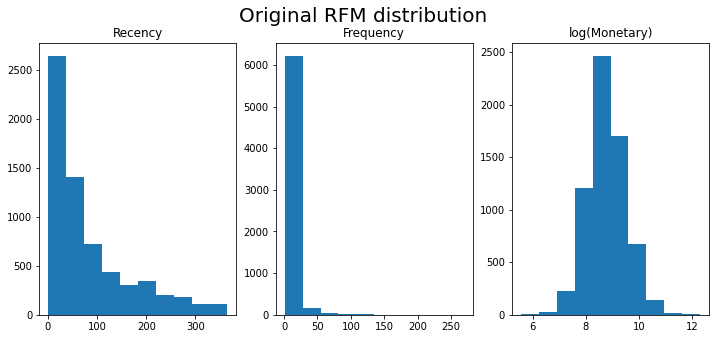

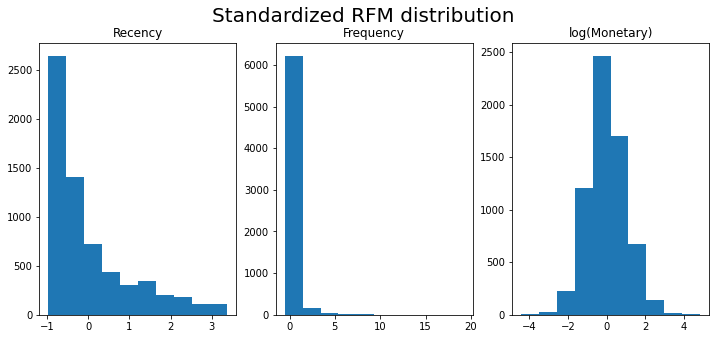

In [ ]:
# Calculating Recency, Frequency & Monetary
RFM = (transactionByVisit
           .groupby('Card_ID')
           .agg(Most_recent=('Date','max'),
                Frequency=('Date','size'), 
                Monetary=('Amount','mean'))
           )
# Feature Engineering
RFM['Recency'] = (pd.Timestamp(2020, 1, 1, 0) - RFM['Most_recent']).dt.days
RFM['log(Monetary)'] = np.log(RFM['Monetary'])
RFM['Monetary_Annual'] = RFM['Frequency'] * RFM['Monetary']

# Retrieve The design matrix for model building
RFM_design = RFM[['Recency', 'Frequency', 'log(Monetary)']]

# Standardize RFM values
means = np.mean(RFM_design, axis = 0)
std = np.std(RFM_design, axis = 0)
RFM_standardized = (RFM_design - means) / std
RFM_standardized

# Check the distribution of RFM
def plot_rfm(df, name=''):
  fig, ax = plt.subplots(1, 3, figsize=(12,5))
  fig.suptitle(f'{name} RFM distribution', fontsize=20)

  for i, value in enumerate(['Recency', 'Frequency', 'log(Monetary)']):
    ax[i].hist(df[value])
    ax[i].set_title(value)
    
# Plot original RFM
plot_rfm(RFM_design, 'Original')
# Plot standardized RFM
plot_rfm(RFM_standardized, 'Standardized')


## **III. Modeling - RFM clustering** 
We segment members into 7 clusters based on Recency, Frequency & Monetary values, with the help of machine learning model (Spectral clustering). These clusters help us explore the deeper insights into member preferences &behaviors



### Decide the number of clusters (k) with elbow method

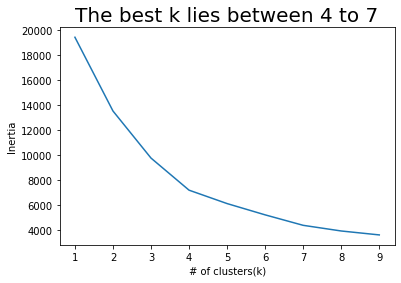

In [ ]:
# Prepare the result matrix
clustered = RFM_standardized.copy()

# Decide the number of cluisters
inertia = []
for i in range(1,10):
  kmeans_cluster = KMeans(n_clusters = i).fit(RFM_standardized)
  inertia.append(kmeans_cluster.inertia_)

# Plot the result
plt.plot(range(1,10), inertia)
plt.xlabel('# of clusters(k)')
plt.ylabel('Inertia')
plt.title('The best k lies between 4 to 7', fontsize=20);

### Clustering with 3 machine learning models (K-Means, Agglomerative Clustering & Spectral Clustering)

In [ ]:
''' Modeling '''
# K-means Clustering
kmeans_cluster = KMeans(n_clusters = 7, random_state=100).fit(RFM_standardized)  
clustered['Cluster_Kmeans'] = [str(label) for label in kmeans_cluster.labels_]

# Agglomerative Clustering
agg_cluster = cluster.AgglomerativeClustering(n_clusters = 7, linkage= 'complete').fit(RFM_standardized)
clustered['Cluster_Agg'] = [str(label) for label in agg_cluster.labels_]

# Spectral Clustering
spectral_cluster = cluster.SpectralClustering(n_clusters=7, affinity="nearest_neighbors", random_state=10).fit(RFM_standardized) 
clustered['Cluster_Spectral'] = [str(label) for label in spectral_cluster.labels_]


In [ ]:
''' Plotting '''
def plot_cluster(model, name):
  fig = px.scatter_3d(clustered, x='Recency', y='Frequency', z='log(Monetary)', color=model, width=600, height=500, title=name)
  fig.update_layout(paper_bgcolor="LightSteelBlue") #, margin=dict(l=20, r=20, t=20, b=30)
  fig.show()

plot_cluster(model='Cluster_Kmeans', name='K-means Clustering')
print()
plot_cluster(model='Cluster_Agg', name='Agglomerative Clustering')
print()
plot_cluster(model='Cluster_Spectral', name='Spectral Clustering')

### Compare different clustering models
***We pick Spectral among all 3 models***, for 
1. Spectral provides a mor evenly distributed clustering, rather than being heavily concentrated in a few clusters.
2. Based on the 3D scatter plots, Spectral suggests a more intuitive model with higher interpretability

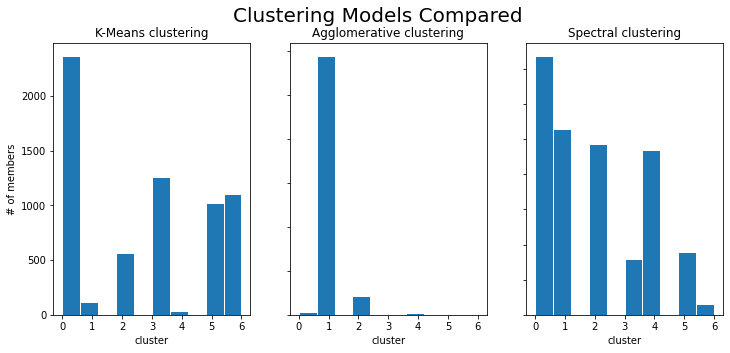

In [ ]:
model_name = {'Cluster_Kmeans': 'K-Means clustering',
              'Cluster_Agg': 'Agglomerative clustering',
              'Cluster_Spectral': 'Spectral clustering',
              }

fig, ax = plt.subplots(1, 3, figsize=(12,5))
fig.suptitle('Clustering Models Compared', fontsize=20)

for i, (model, figName) in enumerate(model_name.items()):
  ax[i].hist(clustered[model].sort_values(), edgecolor='w')
  ax[i].set_title(figName)
  ax[i].set_xlabel('cluster')
  ax[i].set_ylabel('# of members')
  ax[i].label_outer()  # hide the inner overlapping ticks & labels  

### Tagging Data with Clusters

In [ ]:
# Join raw RFM statistics with clustering result, and merge back to the membership_full table
RFM_clustered = RFM.join(clustered['Cluster_Spectral']).reset_index()

membership_clustered = membership_full.merge(
    RFM_clustered[['Card_ID', 'Recency', 'Frequency', 'Monetary', 'Monetary_Annual', 'Cluster_Spectral']],
    how = 'left',
    left_on = 'Card_ID',
    right_on = 'Card_ID'
)

transactionWithCat_Clustered = transactionWithCat.merge(
    RFM_clustered[['Card_ID', 'Cluster_Spectral']],
    how='left',
    left_on='Card_ID',
    right_on='Card_ID'
)

rewards_clustered = rewards_clean.merge(
    RFM_clustered[['Card_ID', 'Cluster_Spectral']],
    how='left',
    left_on='Card_ID',
    right_on='Card_ID'
)

In [ ]:
''' Slice dfs into clusters '''
# Slice the membership table into clusters
MemberClusters = []
for i in range(7):
  MemberClusters.append(membership_clustered[membership_clustered['Cluster_Spectral'] == str(i)])

# Slice the transactions table into clusters
TransClusters = []
for i in range(7):
  TransClusters.append(transactionWithCat_Clustered[transactionWithCat_Clustered['Cluster_Spectral'] == str(i)])

# Slice the rewards table into clusters
RewardClusters = []
for i in range(7):
  RewardClusters.append(rewards_clustered[rewards_clustered['Cluster_Spectral'] == str(i)])

## **IV. Understading** the clusters
These clusters can be summarized by labels
0. Quarterly
1. Monthly
2. Most valuable
3. Churned (highest)
4. Semi-annually
5. Churned
6. Most loyal

With the statistics & visualization below

In [ ]:
# Group statistics
groups = (membership_clustered
          .groupby('Cluster_Spectral', as_index=False)
          .agg(Size=('Card_ID','size'),
               Revenue=('Monetary_Annual','sum'),
               MidR=('Recency','median'),
               MidF=('Frequency','median'),
               MidM=('Monetary','median'),
               MinR=('Recency','min'),
               MaxR=('Recency','max'),
               MinF=('Frequency','min'),
               MaxF=('Frequency','max'),
               MinM=('Monetary','min'),
               MaxM=('Monetary','max'))
          )

groups['% Members'] = 100 * groups['Size'] / groups['Size'].sum()
groups['% Revenue'] = 100 * groups['Revenue'] / groups['Revenue'].sum()
groups['Customer Value'] = groups['Revenue'] / groups['Size']

# Adding a summarizing label describing each cluster
groups['label'] = ['Quarterly', 
                   'Monthly', 
                   'Most valuable', 
                   'Churned (highest)', 
                   'Semi-annually', 
                   'Churned', 
                   'Most loyal']
groups

,Cluster_Spectral,Size,Revenue,MidR,MidF,MidM,MinR,MaxR,MinF,MaxF,MinM,MaxM,% Members,% Revenue,Customer Value,label
0,0,1867,64287812.0,32.0,5.0,5716.750000,1,85,1,21,3694.400000,8909.300000,28.417047,20.776183,34433.750402,Quarterly
1,1,1345,49869538.0,24.0,10.0,2895.361111,1,154,2,51,369.657143,10988.204082,20.471842,16.116564,37077.723420,Monthly
2,2,1236,96093742.0,39.0,3.0,12614.912500,1,161,1,48,6636.125000,158485.666667,18.812785,31.055049,77745.745955,Most valuable
3,3,395,16688378.0,271.0,1.0,20941.000000,135,365,1,22,10156.000000,220000.000000,6.012177,5.393259,42249.058228,Churned (highest)
4,4,1188,34908968.0,128.0,4.0,7385.166667,70,219,1,22,2270.500000,17588.555556,18.082192,11.281689,29384.653199,Semi-annually
5,5,460,25769527.0,239.0,4.0,6251.000000,150,357,1,94,825.403226,13524.500000,7.001522,8.328055,56020.710870,Churned
6,6,79,21812366.0,3.0,76.0,2467.862595,1,123,45,269,261.552632,9734.692308,1.202435,7.049201,276105.898734,Most loyal


In [ ]:
fig = px.scatter_3d(groups, x='MidR', y='MidF', z='MidM', color='Cluster_Spectral', width=600, height=500, 
                    title='Visualizing the RFM distribution of each cluster')
fig.update_layout(
        # margin=dict(l=20, r=20, t=20, b=30),
        paper_bgcolor="LightSteelBlue")
fig.show()

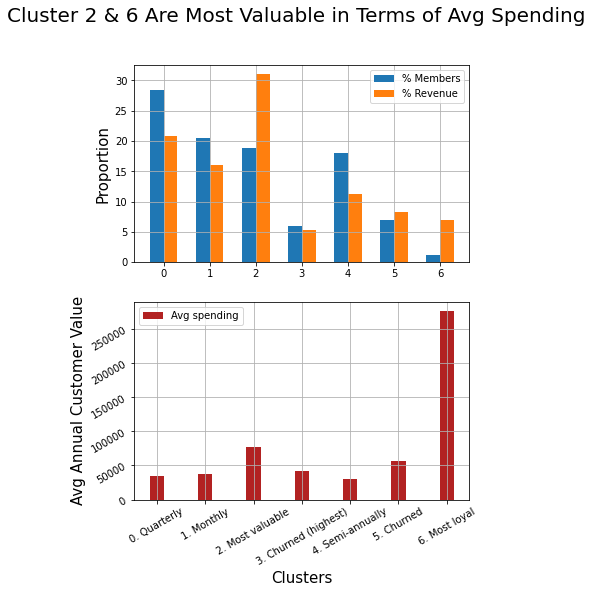

In [ ]:
# Plot the proportion of member count & revenue by cluster
labels = [(f"{i}. " + groups['label'][i]) for i in range(7)]
x = np.arange(len(labels))
width = 0.3

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6,8))
fig.suptitle('Cluster 2 & 6 Are Most Valuable in Terms of Avg Spending', fontsize=20)
ax1.bar(x - width / 2, groups['% Members'], width, label='% Members')
ax1.bar(x + width / 2, groups['% Revenue'], width, label='% Revenue')
ax1.set_ylabel('Proportion', fontsize=15)
ax1.legend()
ax1.grid();

# Plot the Average Annual customer value by cluster
ax2.bar(x, groups['Customer Value'], .3, color='firebrick', label='Avg spending')
ax2.tick_params(labelrotation=30, labelsize=10)
ax2.set_xlabel('Clusters', fontsize=15)
ax2.set_ylabel('Avg Annual Customer Value', fontsize=15)
ax2.legend()
ax2.grid()
plt.xticks(x, labels);

## **V. Behavior Patterns for Each Cluster**
We explore the differences between clusters in terms of geography, age, gender, favored category, favored reward campaign & most popular registered month.

### Geography
The differences aren't significant given the fairly small member base, but would be an useful information once the business grows.

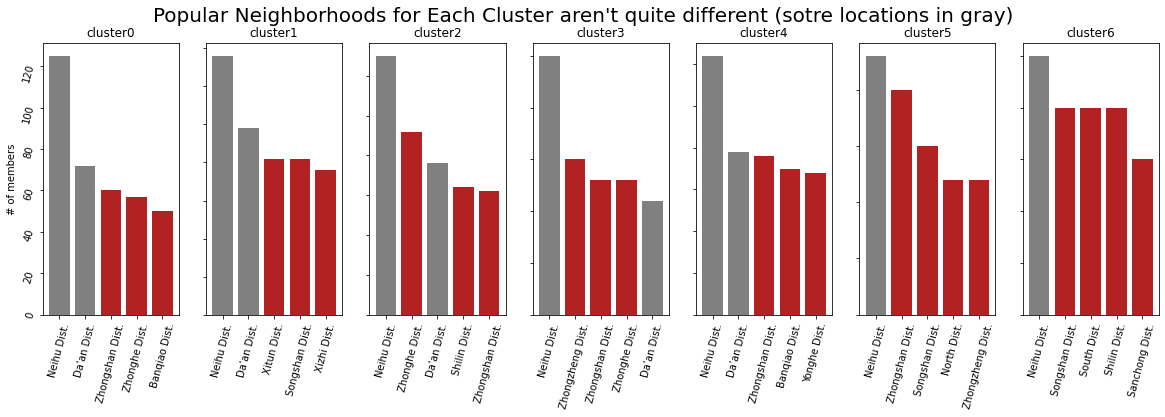

In [ ]:
# Plot the top 5 address (town) of each cluster
Town = []
for i in range(7):
  Town.append(MemberClusters[i]['Town'].value_counts().head())

fig, ax = plt.subplots(1, 7, figsize=(20,5))
for i in range(7):
  colorlist = ['grey' 
               if town in ['Neihu Dist.', "Da’an Dist."] 
               else 'firebrick' 
               for town in Town[i].index]
  ax[i].bar(Town[i].index, Town[i], color = colorlist)
  ax[i].tick_params(labelrotation=75)
  ax[i].set_title(f"cluster{i}")
  ax[i].set(ylabel='# of members')
  ax[i].label_outer()  # hide the inner overlapping ticks & labels
fig.suptitle("Popular Neighborhoods for Each Cluster aren't quite different (sotre locations in gray)", fontsize=20);   

### Age
Cluster 6 has more members between age 30-40 & 60-70, while other clusters being almost identical

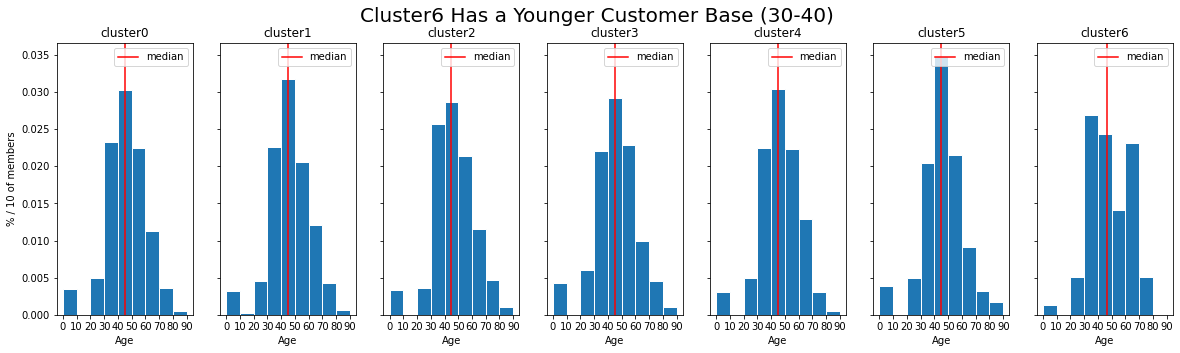

In [ ]:
# Plot the age distribution by cluster
fig, ax = plt.subplots(1, 7, figsize=(20,5), sharey = True)
for i in range(7):
  ax[i].hist(MemberClusters[i]['Age'], edgecolor='w', bins=np.arange(0,100,10), density=True)
  ax[i].axvline(x=MemberClusters[i]['Age'].median(), color='r', label='median')
  ax[i].set_title(f"cluster{i}")
  ax[i].set_xticks(range(0,100,10))
  ax[i].legend()
  ax[i].set(xlabel='Age', ylabel='% / 10 of members')
  ax[i].label_outer()  # hide the inner overlapping ticks & labels
  
fig.suptitle('Cluster6 Has a Younger Customer Base (30-40)', fontsize=20);    

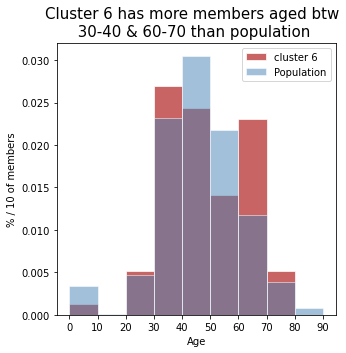

In [ ]:
# Cluster 6 vs. population
plt.figure(figsize=(5, 5))
plt.hist(MemberClusters[6]['Age'], edgecolor='w', bins=np.arange(0,100,10), density=True, label='cluster 6', alpha=.7, color='firebrick')
plt.hist(membership_clustered['Age'], edgecolor='w', bins=np.arange(0,100,10), density=True, label='Population', alpha=.5, color='steelblue')
txt = '''Cluster 6 has more members aged btw
 30-40 & 60-70 than population'''
plt.figtext(.5, .9, txt, ha='center', fontsize=15)
plt.xticks(range(0,100,10))
plt.xlabel('Age')
plt.ylabel('% / 10 of members')
plt.legend();

### Gender
Cluster 6 has higher % of female, while other clusters being almost the same

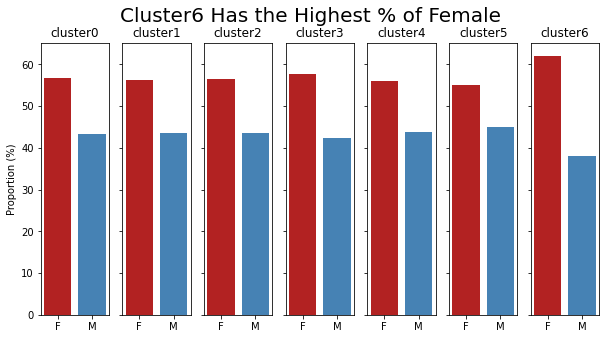

In [ ]:
# Plot the gender ratio by cluster
fig, ax = plt.subplots(1, 7, figsize=(10,5), sharey=True)
for i in range(7):
  genderRatio = 100 * MemberClusters[i]['Gender'].value_counts() / MemberClusters[i]['Gender'].value_counts().sum()
  colorlist = ['firebrick' if sex == 'F' else 'steelblue' for sex in genderRatio.index]
  ax[i].bar(genderRatio.index, genderRatio, color=colorlist)
  ax[i].set_title(f"cluster{i}")
  ax[i].set(ylabel='Proportion (%)')
  ax[i].label_outer()  # hide the inner overlapping ticks & labels
fig.suptitle('Cluster6 Has the Highest % of Female', fontsize=20);

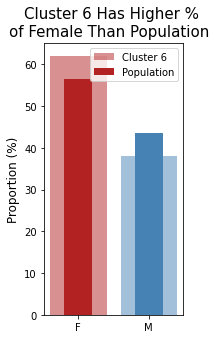

In [ ]:
# Zoom in - Cluster 6 vs. population
ratio6 = 100 * MemberClusters[6]['Gender'].value_counts() / MemberClusters[6]['Gender'].value_counts().sum()
ratioPop = 100 * membership_clustered['Gender'].value_counts() / membership_clustered['Gender'].value_counts().sum()
col = ['firebrick' if sex == 'F' else 'steelblue' for sex in genderRatio.index]

plt.figure(figsize=(2.5, 5))
plt.bar(ratio6.index, ratio6, color=col, alpha=.5, label='Cluster 6')
plt.bar(ratioPop.index, ratioPop, color=col, label='Population', width=.4)
plt.legend()
plt.ylabel('Proportion (%)', fontsize=12)
txt = '''Cluster 6 Has Higher %
of Female Than Population '''
plt.figtext(.5, .9, txt, ha='center', fontsize=15);

### Category
- Cluster 2: spend most on fashion, dining in the outlet as well
- Cluster 6: spend most on sportswear, while also buying for kids
- Others: less on expensive fashion brands

/usr/local/lib/python3.7/dist-packages/matplotlib/colors.py:263: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



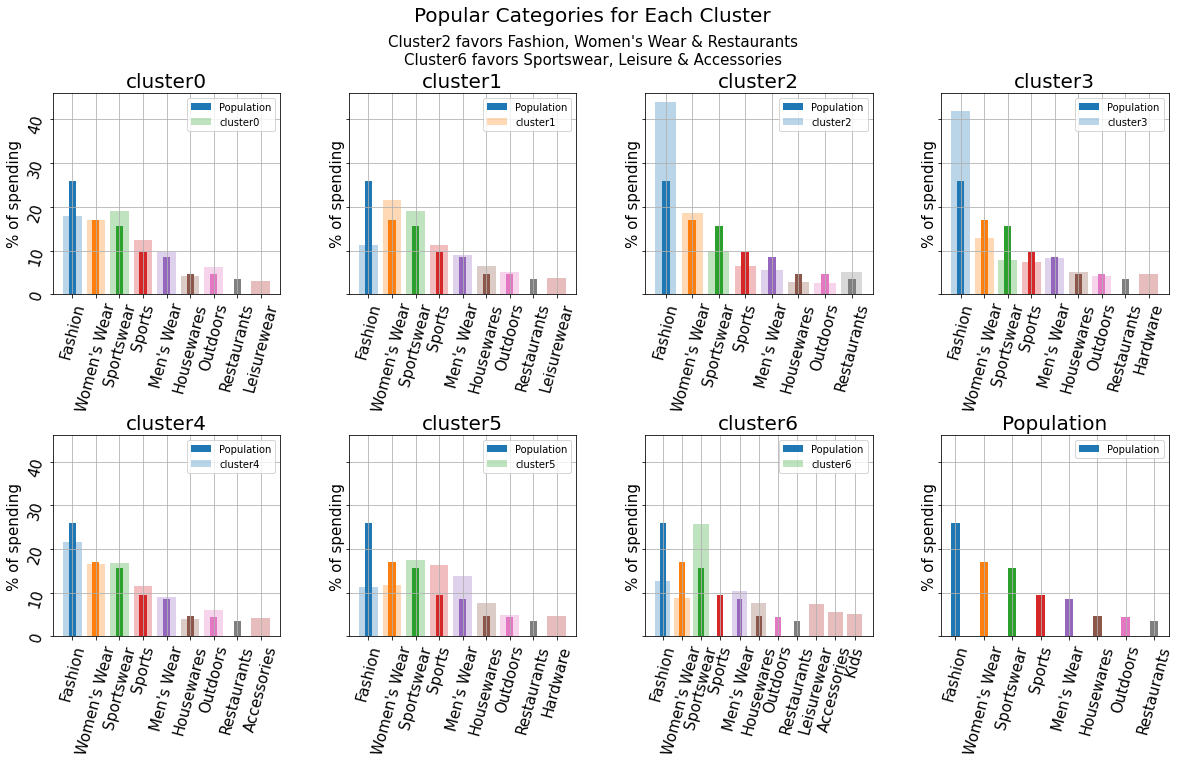

In [ ]:
# Plot the top categories (in terms of $ spending) by cluster (wider transparent bar), compared with population (narrower solid bars)
categoryAmount = []
for i in range(7):
  categoryAmount.append(
      100 * TransClusters[i].groupby('Category').sum()['Amount'].sort_values(ascending=False).head(8) / TransClusters[i].groupby('Category').sum()['Amount'].sum()
  )

# Count across all clusters (population)
categoryAmount.append(
    100 * transactionWithCat.groupby('Category').sum()['Amount'].sort_values(ascending=False).head(8) / transactionWithCat.groupby('Category').sum()['Amount'].sum()
)

# Colormap
items = transactionWithCat.groupby('Category').sum()['Amount'].sort_values(ascending=False).head(8).index.values
colorDict = {items[i]: plt.cm.get_cmap('tab10')(i) for i in range(8)}

# Plot the distribution
txt = '''Cluster2 favors Fashion, Women's Wear & Restaurants
Cluster6 favors Sportswear, Leisure & Accessories'''
fig, ax = plt.subplots(2, 4, figsize=(20,10), sharey=True)
fig.suptitle(x=.5, y=1.0, t='Popular Categories for Each Cluster', fontsize=20)
fig.text(.5, .92, txt, ha='center', fontsize=15)
plt.subplots_adjust(wspace=0.3, hspace=0.7)

# Plot each cluster respectively
for i in range(8):
  colorlist = [colorDict[cat] 
               if cat in colorDict.keys() 
               else 'firebrick' 
               for cat in categoryAmount[i].index]
  axi = ax.ravel()[i]
  
  # Plot Population in the background
  axi.bar(categoryAmount[7].index, categoryAmount[7], color=colorDict.values(), label='Population', width=0.3)
  
  # If not population, plot the cluster in lighter wider bars
  if i != 7:
    axi.set_title(f"cluster{i}", fontsize=20)
    axi.bar(categoryAmount[i].index, categoryAmount[i], color=colorlist, alpha=.3, label=f"cluster{i}")
  else:
    axi.set_title("Population", fontsize=20)
  
  # Labels
  axi.tick_params(labelrotation=75, labelsize=15)
  axi.set_ylabel('% of spending', fontsize=15)
  axi.legend()
  axi.grid();

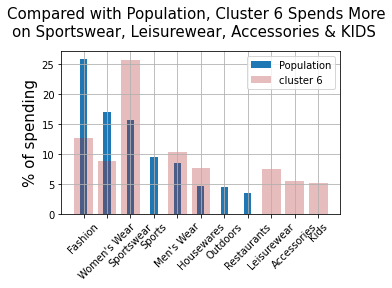

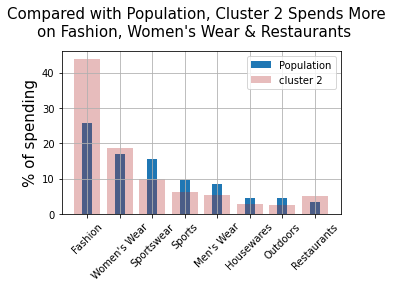

In [ ]:
# Zoom in - Plot individual cluaster against population

def plot_cat_individual(c, txt): # c: cluster index
  plt.figure(figsize=(5, 3))
  # Plot Population in the background
  plt.bar(categoryAmount[7].index, categoryAmount[7], label='Population', width=0.3)
  # plot the specific cluster
  plt.bar(categoryAmount[c].index, categoryAmount[c], alpha=.3, label=f"cluster {c}", color='firebrick')

  # Labels
  plt.xticks(rotation=45)
  plt.ylabel('% of spending', fontsize=15)
  plt.legend()
  plt.grid()
  plt.figtext(.5, .95, txt, ha='center', fontsize=15);

txt6 = '''Compared with Population, Cluster 6 Spends More
on Sportswear, Leisurewear, Accessories & KIDS '''

txt2 = '''Compared with Population, Cluster 2 Spends More
on Fashion, Women's Wear & Restaurants '''

# Plot cluster 6
plot_cat_individual(6, txt6)

# Plot cluster 2
plot_cat_individual(2, txt2)

### Reward Campaign
Reward campaign performs indifferently across all clusters. This might be because reward is not the driver for outlet shopping, but direct discounts!

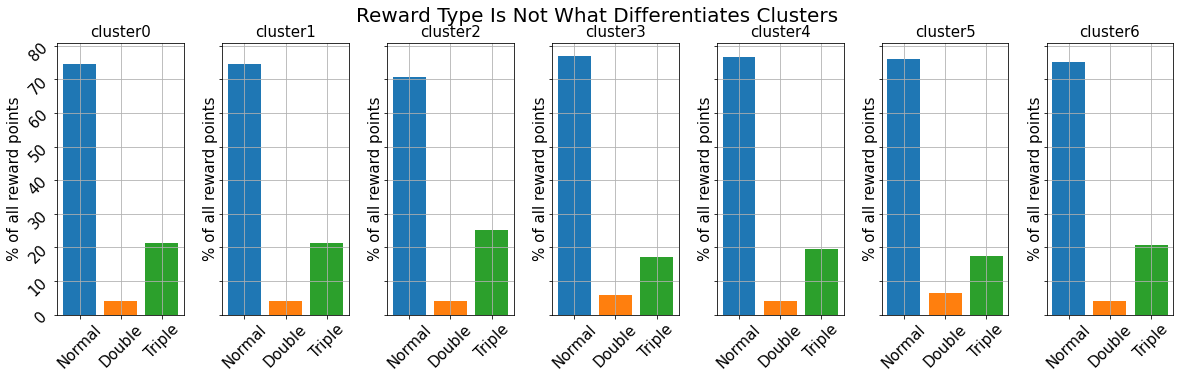

In [ ]:
# Plot the points collected by reward campaign type, by cluster
fig, ax = plt.subplots(1, 7, figsize=(20,5), sharey=True)
fig.suptitle('Reward Type Is Not What Differentiates Clusters', fontsize=20)
plt.subplots_adjust(wspace=0.3)

for i in range(7):
  # Sum the amount of points earned per campaign type
  camSum = RewardClusters[i][['Campaign_code', 'points']].groupby('Campaign_code').sum().loc[['Normal', 'Double', 'Triple'], :]
  camRatio = 100 * camSum['points'] / camSum['points'].sum()

  ax[i].bar(camRatio.index, camRatio, color = plt.cm.tab10.colors[:3])#, color=colorlist)
  ax[i].set_ylabel('% of all reward points', fontsize=15)
  ax[i].tick_params(labelrotation=45, labelsize=15)
  ax[i].set_title(f"cluster{i}", fontsize=15)
  ax[i].grid();

### Registration Month
- Marketing or promotion campaigns in November are most effective in acquiring cluster 2 (most valuable) members
- Most infrequent members were acquired in October, indicating that campaigns in October were inefficient

In [ ]:
# Prepare the data we need - Regeistered_month
membership_clustered['Regeistered_month'] = membership_clustered['Regeistered_month'].dropna().astype(int)

# Calculate the new member by month by cluster
newMemberByMonth = membership_clustered.groupby(['Cluster_Spectral', 'Regeistered_month']).size().sort_index().reset_index().rename(columns={0: '# of new members'})

# Plot - cluster 2 & 6
fig = px.line(newMemberByMonth, 
              x='Regeistered_month', 
              y='# of new members', 
              color='Cluster_Spectral', 
              title='Most cluster 2 & 6 are acquired in November & September respectively',
              width=600, height=400)

# Plot - other clusters
fig1 = px.area(newMemberByMonth, 
              x='Regeistered_month', 
              y='# of new members', 
              color='Cluster_Spectral', 
              title='Most infrequent members are acquired in Octobor',
              width=600, height=400)

fig.show()
fig1.show()

### Sales by category
Based on the previous analysis, the most valuable members (cluster 2) spend mostly on fashion, which is the biggest source of sales revenue found here. We can conclude that fashion is the most profitable category and worth greater investment

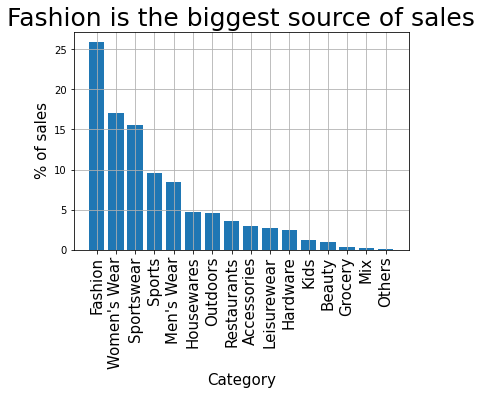

In [ ]:
# Plot the percentage sales by category
salesByCat = transactionWithCat[['Category', 'Amount']].groupby('Category').sum().sort_values('Amount', ascending=False)
salesByCat['%'] = 100* salesByCat['Amount'] / salesByCat['Amount'].sum()

plt.bar(salesByCat.index, salesByCat['%'])
plt.xlabel('Category', fontsize=15)
plt.ylabel('% of sales', fontsize=15)
plt.title('Fashion is the biggest source of sales', fontsize=25)
plt.grid()
plt.xticks(rotation=90, fontsize=15);

## VI. Summary
Based on our analysis above, we found the preferences, shopping patterns & growth opportunities for each cluster of members
- Most valuable members (cluster 6): 
  - Generate **31% of sales with 19% of members**, rank the **second highest annual spending per person ($78k)**
  - Spend mostly (45%) on fashion brands, which is also the biggest source of the outlet's sales. Interestingly, with higher budgets & longer stay per visit, the also spend more on restaurants than the population
  - Accordingly, we can try to introduce other complementary needs (ie. entertainment) to **YIELD HIGHER SPENDING PER VISIT** from these members
- Most frequent members (cluster 2)
  - Generate **7% of sales** with only **1% of members**, rank by far the **highest annual spending per person (276k)**
  - Spend mostly (25%) on sportswear brands, also on leisurewear, accessories & kids. Based on the age, gender & purchase pattern, we can infer they are young moms & retired women, who are keen to visit very frequently (median 76 times a year) to get best deals (relatively low spending per visit, 2.5k)
  - As a result, instead of increasing their visit frequency or spending per visit, it'll be cost efficient to **ACQUIRE MORE SUCH MEMBERS** (ie. member get member campaign)
- Others
  - Either visit infrequently or buy less with cheaper items per visit, they have the lowest annual value per person (34~56k)
  - We can start with catering to more common needs (ie. restaurants) to **INCREASE THEIR FREQUENCY OF VISITING**